# Joyce: Data Exploration

In [41]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

## Raw data (WRDS - OptionMetrics)
- Option prices
  - secid
  - date
  - exdate: Expiration Date of the Option
  - cp_flag: C=Call, P=Put
  - strike_price
  - best_bid: Highest Closing Bid Across All Exchanges
  - best_offer: Lowest Closing Ask Across All Exchanges
  - volume
  - open_interest: Open Interest for the Option
      - volume > 0 or open_interest > 0 (Exclude illiquid options)
  - impl_volatility: Implied Volatility of the Option
      - impl_volatility IS NOT NULL (Exclude options without valid IVs)
  - delta
      - delta BETWEEN 0.4 AND 0.6 (Focus on near-the-money call options at the moment to begin with)
  - gamma
  - vega
  - theta
  - optionid: Unique ID for the Option Contract
  - forward_price
  - ticker
      
- Security prices
    - cusip
    - ticker
    - low
    - high
    - open
    - close
    - volume
    - return
    - cfadj: Cumulative Adjustment Factor
    - shrout: Shares Outstanding
    - cfret: Cumulative Total Return Factor
- Timeframe: 2019-08-31 to 2023-08-31 (past 5 years)

In [4]:
option_prices=pd.read_csv('option_prices.csv')
security_prices=pd.read_csv('security_prices.csv')

In [5]:
option_prices.head()

,secid,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,forward_price,ticker,index_flag,issuer,exercise_style
0,5139,2019-09-11,2019-09-20,C,25000,0.15,1.10,10,68,0.343533,0.557537,0.295407,1.556030,-11.408580,129252248,NaN,CAE,0,CAE INC.,A
1,5139,2019-09-11,2019-12-20,C,25000,1.30,1.55,9,161,0.244224,0.559077,0.121502,5.189608,-2.573650,129252254,NaN,CAE,0,CAE INC.,A
2,5139,2019-09-23,2019-12-20,C,25000,1.05,1.55,2,151,0.214016,0.590211,0.145929,4.836180,-2.426186,129252254,NaN,CAE,0,CAE INC.,A
3,5139,2019-10-04,2019-12-20,C,25000,0.85,1.00,10,153,0.257508,0.452210,0.136639,4.441096,-2.604873,129252254,NaN,CAE,0,CAE INC.,A
4,5139,2019-10-08,2019-12-20,C,25000,0.70,0.90,3,143,0.255023,0.423140,0.141820,4.237122,-2.884659,129252254,NaN,CAE,0,CAE INC.,A


In [6]:
option_prices.shape

(22514868, 20)

In [7]:
security_prices.head()

,secid,date,cusip,ticker,low,high,open,close,volume,return,cfadj,shrout,cfret
0,5017,2020-07-27,01074220,AXO,25.11,25.40,25.35,25.1975,7865,NaN,1.0,0,1.0000
1,5139,2022-06-17,12476510,CAE,22.31,23.00,22.36,22.8000,259442,0.021048,1.0,316984,1.3223
2,5139,2023-08-08,12476510,CAE,21.81,22.37,22.33,22.0800,238937,-0.025166,1.0,318089,1.3223
3,5139,2023-04-19,12476510,CAE,23.42,23.82,23.66,23.5700,110549,-0.011740,1.0,317852,1.3223
4,5139,2020-09-01,12476510,CAE,15.51,16.05,15.66,15.9000,334125,0.005693,1.0,265777,1.3223


In [8]:
security_prices.shape

(9290729, 13)

## Clean, Merge, and Filter

In [10]:
# Convert date columns to datetime
option_prices['date'] = pd.to_datetime(option_prices['date'])
option_prices['exdate'] = pd.to_datetime(option_prices['exdate'])
security_prices['date'] = pd.to_datetime(security_prices['date'])

In [11]:
# Convert strike price back to original
option_prices['strike_price'] = option_prices['strike_price'] / 1000

In [12]:
# Merge
merged = option_prices.merge(
    security_prices[['secid', 'date', 'close']],
    on=['secid', 'date'],
    how='left',
    suffixes=('', '_underlying')
)

In [21]:
# Calculate additional variables
merged['date_to_expiration'] = (merged['exdate'] - merged['date']).dt.days
merged['moneyness'] = merged['strike_price'] / merged['close']
merged['mid_price'] = (merged['best_bid'] + merged['best_offer']) / 2

In [25]:
# Filter to find 20-45 day to expiration window (potentially most relevant to earnings events)
filtered = merged[
    (merged['volume'] > 0) &
    (merged['impl_volatility'].notna()) &
    (merged['date_to_expiration'] >= 20) & (merged['date_to_expiration'] <= 45) &
    (merged['delta'].between(0.4, 0.6))
]

In [27]:
filtered.head()

,secid,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,forward_price,ticker,index_flag,issuer,exercise_style,close,date_to_expiration,moneyness,mid_price
15,6505,2019-12-03,2020-01-17,C,40.0,0.50,0.65,5,7,0.145648,0.408616,0.192779,5.371610,-3.453715,131324825,NaN,FTS,0,FORTIS INC.,A,39.39,45,1.015486,0.575
17,6505,2019-12-05,2020-01-17,C,40.0,0.60,0.75,1,9,0.139194,0.472997,0.209585,5.428967,-3.535874,131324825,NaN,FTS,0,FORTIS INC.,A,39.74,43,1.006543,0.675
18,6505,2019-12-09,2020-01-17,C,40.0,0.75,1.05,251,9,0.151630,0.551654,0.198824,5.189699,-4.071255,131324825,NaN,FTS,0,FORTIS INC.,A,40.13,39,0.996761,0.900
72,8170,2019-09-17,2019-10-18,C,17.5,0.40,0.70,12,43,0.386878,0.420514,0.204306,1.933784,-4.540353,130184530,NaN,MPAA,0,MOTORCAR PARTS OF AMERICA IN,A,16.97,31,1.031232,0.550
73,8170,2019-10-21,2019-11-15,C,17.5,0.40,1.95,55,40,0.721475,0.505033,0.122721,1.796855,-9.599298,130640433,NaN,MPAA,0,MOTORCAR PARTS OF AMERICA IN,A,17.21,25,1.016851,1.175


## Exploratory Data Analysis

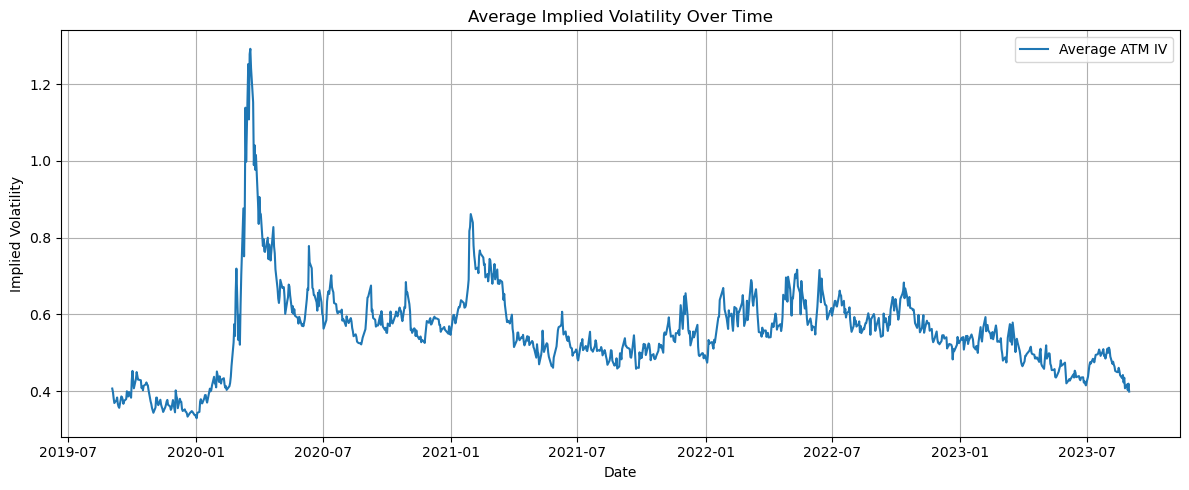

In [33]:
# Implied volatility over time

# Group by date and take mean implied volatility
daily_iv = filtered.groupby('date')['impl_volatility'].mean()

plt.figure(figsize=(12, 5))
plt.plot(daily_iv.index, daily_iv.values, label='Average ATM IV')
plt.title('Average Implied Volatility Over Time')
plt.ylabel('Implied Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

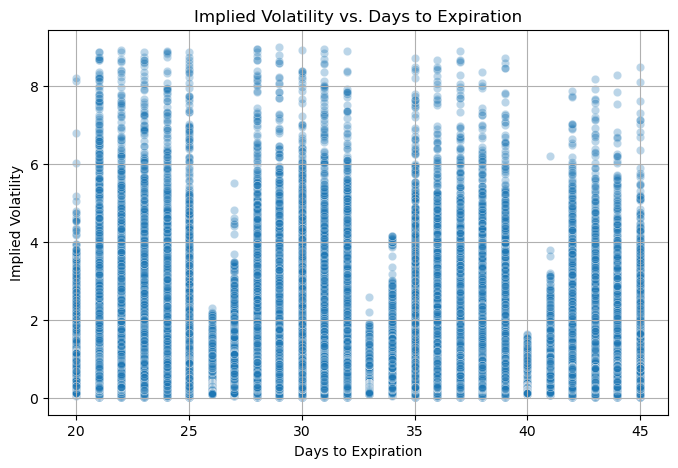

In [45]:
# Implied Volatility vs. Days to Expiration
plt.figure(figsize=(8, 5))
sns.scatterplot(data=filtered, x='date_to_expiration', y='impl_volatility', alpha=0.3)
plt.title('Implied Volatility vs. Days to Expiration')
plt.xlabel('Days to Expiration')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.show()

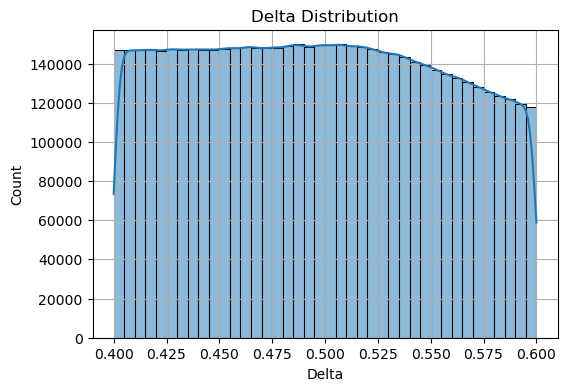

In [49]:
# Delta distribution
plt.figure(figsize=(6, 4))
sns.histplot(filtered['delta'], bins=40, kde=True)
plt.title('Delta Distribution')
plt.xlabel('Delta')
plt.grid(True)
plt.show()

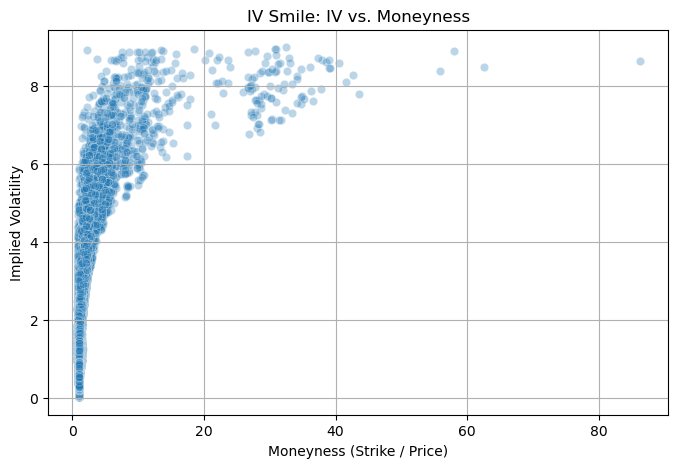

In [51]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=filtered, x='moneyness', y='impl_volatility', alpha=0.3)
plt.title('IV Smile: IV vs. Moneyness')
plt.xlabel('Moneyness (Strike / Price)')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.show()